In [1]:
import numpy as np
import pandas as pd
from helper import parse_data, get_data, transform_text, remove_url
import contractions
import gensim
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [2]:
tags = ['title', 'author', 'selftext', 'link_flair_text', 'num_comments']
file = 'data/data1651077368.json'
data = get_data(file)
df = parse_data(data, tags)
df = df.replace(r'^\s*$', np.NaN, regex=True)
df.dropna(subset=['selftext'], inplace=True)
df.head()

,title,author,selftext,link_flair_text,num_comments
1,Accuracy vs rating,brtkll,"If you analyze most of your games, what's your...",Miscellaneous,0
2,Refusing a draw,voneklee,I had a drawn position and my opponent asked t...,Chess Question,3
3,Does anyone else resign to punish yourself whe...,HicSuntStulti,"Like, when I screw up monumentally in a way th...",Miscellaneous,6
4,Most invisible chess Grandmaster?,dXFGHBJNKJHBHGTFDSRA,Grandmasters that is as strong as the top play...,Chess Question,5
5,Chess set recommendation.,Careful_Mirror6886,I’m a beginner 1100 on rapid and I want to get...,Chess Question,3


## Pre-Processing

In [3]:
def preprocess(text):
    if text:
        text = remove_url(text)
        text = contractions.fix(text)
        return gensim.utils.simple_preprocess(text)
    return text

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    words = []
    for word in text:
        if word not in stop_words:
            words.append(word)
    return words

def stem_lemmatize(text):
    stemmer = LancasterStemmer()
    lemmatizer = WordNetLemmatizer()
    words = []
    for word in text:
        #word = stemmer.stem(word)
        word = lemmatizer.lemmatize(word, pos='v')
        words.append(word)
    return words


def func(text):
    tags = text.apply(nltk.pos_tag)
    tags
    sentences = []
    for sentence in tags:
        words = []
        for word in sentence:
            if word[1] in ('NN', 'JJ'):
                words.append(word[0])
        sentences.append(words)
    return sentences

In [4]:
stop_text = df.selftext.apply(preprocess)
no_stop_text = df.selftext.apply(preprocess).apply(remove_stop_words)
#no_stop_text = pd.Series(func(no_stop_text)) 


### EDA


In [5]:
def get_top_k_n_grams(text, k=10, n=1):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k] 


In [6]:
sns.set(font='Roboto',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})
sns.despine(left=True, bottom=True)


<Figure size 432x288 with 0 Axes>

   words  count
0  chess   2280
1   game   2220
2   play   1860
3   move   1800
4   like   1740


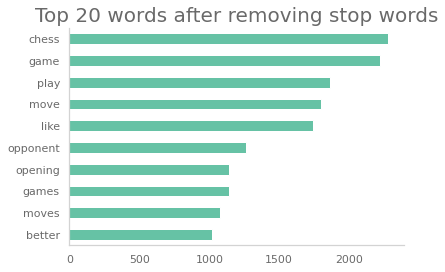

In [26]:
common_words = get_top_k_n_grams(no_stop_text.apply(' '.join))
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])
#plt.figure(figsize=(12,12))
print(df1.head())
#plt.barh(df1, df1.count)
df1.groupby('words').sum()['count'].sort_values(ascending=True).plot(
    kind='barh', color=sns.color_palette('Set2')[0], title='Top 10 words after removing stop words')

plt.ylabel('')
plt.show()
#plt.legend(frameon=False)

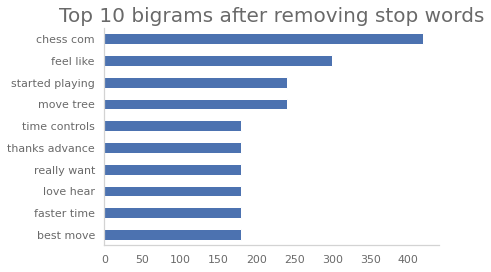

In [29]:

common_words = get_top_k_n_grams(no_stop_text.apply(' '.join), n=2)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])
#plt.figure(figsize=(12,12))
df1.groupby('words').sum()['count'].sort_values(ascending=True).plot(
    kind='barh', title='Top 10 bigrams after removing stop words')

plt.ylabel('')
plt.show()

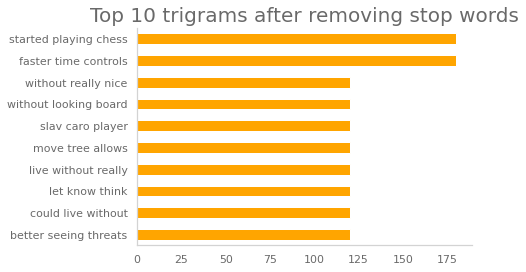

In [28]:
common_words = get_top_k_n_grams(no_stop_text.apply(' '.join), n=3)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])
#plt.figure(figsize=(12,12))
df1.groupby('words').sum()['count'].sort_values(ascending=True).plot(
    kind='barh', color='orange', title='Top 10 trigrams after removing stop words')

plt.ylabel('')
plt.show()
#common_words

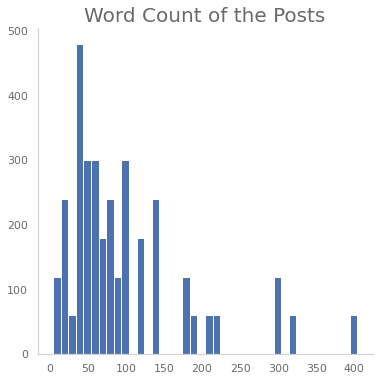

In [27]:
#plt.hist(stop_text.apply(len))
data=stop_text.apply(len)
n = math.ceil((data.max() - data.min())/10)
plt.figure(figsize=(6,6))
plt.hist(stop_text.apply(len), bins= n)
plt.title('Word Count of the Posts')
plt.show()


70


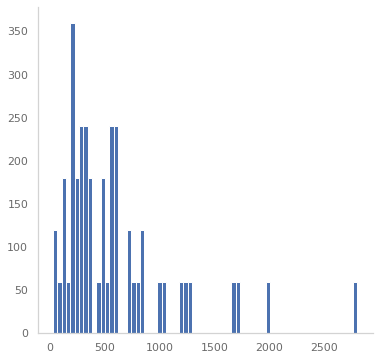

In [11]:

data=df.selftext.apply(len)
n = math.ceil((data.max() - data.min())/40)
print(n)
plt.figure(figsize=(6,6))
plt.hist(data, bins= n)
plt.show()


In [12]:
def func(text):
    tags = text.apply(nltk.pos_tag)
    tags
    sentences = []
    for sentence in tags:
        words = []
        for word in sentence:
            if word[1] == 'NN':
                words.append(word[0])
        sentences.append(words)
    return sentences

In [13]:
tags = no_stop_text.apply(nltk.pos_tag)
tags

1       [(analyze, JJ), (games, NNS), (average, JJ), (...
2       [(drawn, VBN), (position, NN), (opponent, NN),...
3       [(like, IN), (screw, NNS), (monumentally, RB),...
4       [(grandmasters, NNS), (strong, JJ), (top, JJ),...
5       [(beginner, NN), (rapid, JJ), (want, VBP), (ge...
                              ...                        
5994    [(hi, NN), (looking, VBG), (electronic, JJ), (...
5996    [(recently, RB), (got, VBD), (cheap, JJ), (che...
5997    [(hi, NN), (lichess, NN), (blitz, NN), (player...
5998    [(game, NN), (report, NN), (sometimes, RB), (s...
5999    [(contact, NN), (chess, NN), (com, NN), (suppo...
Name: selftext, Length: 3300, dtype: object

In [30]:

final = []
for e in tags.tolist():
    final.extend(e)
#tags = tags.apply(pd.Series).stack().reset_index(drop = True)
df5 = pd.DataFrame(final, columns=['word', 'pos'])
df5.head()
pos_df = df5.pos.value_counts()[:20]
#df5 = pd.DataFrame(pos_df, columns=['pos', 'count'], index=False)
plt.figure(figsize=(12,12))
pos_df.head()

pos_df = pos_df.sort_values(ascending=True)
print(type(pos_df))
plt.barh(pos_df.index, pos_df)
plt.title('Top 10 most common Parts of Speech used')
plt.show()

<class 'pandas.core.series.Series'>


Text(0.5, 1.0, 'Top 10 most common Parts of Speech used')